In [1]:
import torch
import os
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from unet import UNet
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torchsummary import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
torch.set_default_dtype(torch.float16)

In [2]:
#FOR COMBINED DATASET OF POS AND NEG
# file = open('/home/turin/Documents/GitHub/long_term_underwater_vision/dataset/data', 'rb')
# np_data = pickle.load(file)
# file.close
# file = open('/home/turin/Documents/GitHub/long_term_underwater_vision/dataset/label', 'rb')
# np_label = pickle.load(file)
# file.close

In [3]:
#For Positive and Negative data separate
file1 = open('/home/turin/Documents/GitHub/long_term_underwater_vision/dataset/dataset_curated', 'rb')
pos_data = pickle.load(file1)
file1.close
im_pos, label_pos = pos_data
im_pos_reduced = im_pos[:5]
label_pos_reduced = label_pos[:5]
transform = transforms.Compose([transforms.ToTensor(), transforms.ConvertImageDtype(torch.float16)])#,transforms.Resize(size=(408,544), interpolation=transforms.InterpolationMode("nearest"))])
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data_path = "/home/turin/Desktop/lizard_island/jackson/chronological/2014/r20141102_074952_lizard_d2_081_horseshoe_circle01/081_photos/"
        img1_path = data_path+self.data[idx][0]
        img2_path = data_path+self.data[idx][1]
        im_bgr1 = cv2.imread(img1_path)
        im_bgr2 = cv2.imread(img2_path)
        im_gray1 = cv2.cvtColor(im_bgr1, cv2.COLOR_BGR2GRAY)
        im_gray2 = cv2.cvtColor(im_bgr2, cv2.COLOR_BGR2GRAY)
        img1 = transform(im_gray1)
        img2 = transform(im_gray2)
        label = self.labels[idx][0]
        pose_img1 = self.labels[idx][1][0]
        pose_img2 = self.labels[idx][1][1]
        #print(img1, img2, label, pose_img1, pose_img2)
        return (img1, img2),(label, pose_img1, pose_img2, (img1_path, img2_path))

training_data = CustomDataset(im_pos_reduced,label_pos_reduced)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=False, num_workers=16)

In [4]:
batch  = iter(train_dataloader)
bl2 = next(batch)
(img1, img2), (label, pos1, pos2, img_path) = bl2 ##((image1, image2),(label, pos1, pos2, (img_path)))
pos1[0], pos2[0]
#img_path[0][0], img_path[1][0]
#len(img1), len(img2)
#im = torch.permute(img1[1],(1,2,0))#, img2[1], label, pos1[1], pos2[1]
#print(img1)

(tensor([[-0.6514, -0.5803, -0.4888, 39.7535],
         [-0.7499,  0.5904,  0.2984, 73.7323],
         [ 0.1154,  0.5609, -0.8198,  6.6106],
         [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64),
 tensor([[-7.6017e-01, -5.0332e-01, -4.1087e-01,  3.9694e+01],
         [-6.4891e-01,  6.1980e-01,  4.4132e-01,  7.3502e+01],
         [ 3.2532e-02,  6.0209e-01, -7.9776e-01,  7.3996e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
        dtype=torch.float64))

In [5]:
img1.shape

torch.Size([1, 1, 1024, 1360])

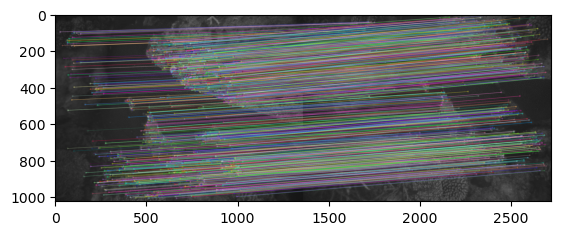

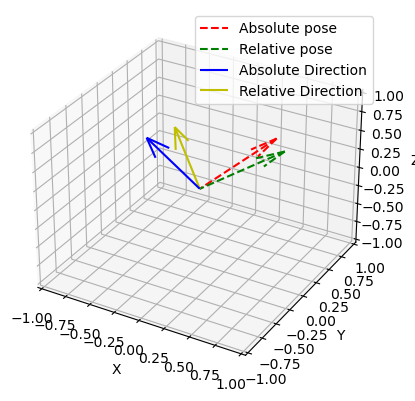

0.26464560235504564 [[0.19226074 1.64701233 1.39463438]
 [1.50216346 0.08428335 1.52195275]
 [1.7501033  1.60670999 0.18294498]]


1.3626528553826611

In [6]:
import sift_pose_est
def poseloss(img1, img2, pose1, pose2):
    im1 = torch.permute(img1,(1,2,0))
    im2 = torch.permute(img2,(1,2,0))
    im1 = im1.numpy(force=True)*255
    im2 = im2.numpy(force=True)*255
    im1 = im1.astype(np.uint8)
    im2 = im2.astype(np.uint8)
    mat1 = pose1
    mat2 = pose2
    # mat1 = pose1.numpy(force=True)
    # mat2 = pose2.numpy(force=True)
    x ,y, len_pts  = sift_pose_est.get_relative_angle(im1, im2, mat1.squeeze(), mat2.squeeze(),display=True)
    print(x, y)
    loss = x+np.sum(np.abs(y))/9
    return loss

poseloss(img1[0], img2[0],pos1[0], pos2[0] )
# class RelativePoseEstimate(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, input):
#         ctx.save_for_backward(input)



In [7]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.mse_loss(output1,output2)
        loss1 = euclidean_distance
        z = torch.clamp(euclidean_distance,min=0,max=3 )
        loss2 = 3 - z
        if label[0]:
            print(1, loss1)
        else:
            print(0, z)
        loss = label[0]*loss1 + (1-label[0])*loss2

        # loss = torch.mean( label * torch.pow(euclidean_distance, 2) +
        #                   (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss
criterion = ContrastiveLoss()
#criterion = nn.ContrastiveLoss()

In [8]:
# criterion(image[0][4], image[1][4], label[0][4]), criterion(image[0][1], image[1][1], label[0][1])
# F.mse_loss(image[0][1], image[1][1])

In [9]:
def create_model():
    # model = torchvision.models.resnet18(pretrained=False, num_classes=2)
    # model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    # model.maxpool = nn.Identity()
    model2 = UNet(in_channels=1,
             out_channels=1,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2)
    return model2
model = create_model()
model.cuda()
####SAVING FROM CHECKPOINT
#summary(m,(3,256,384))
checkpoint = torch.load("/home/turin/Documents/GitHub/long_term_underwater_vision/model/auto_logs/autoencoder/version_9/checkpoints/epoch=2-step=2400.ckpt")
#m.load_state_dict(checkpoint['state_dict'])
check_state = checkpoint['state_dict']
model_state = model.state_dict()
key_list = list(check_state.keys())
len(key_list)
for idx in key_list:
    # print(idx)
    # print(idx[6:])
    model_state[idx[6:]]=check_state[idx]
model.load_state_dict(model_state)

<All keys matched successfully>

In [10]:
from torchvision.models import resnet18
model_resnet = resnet18
#Lightning Model Creation
class LitResnet(pl.LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()
        self.example_input_array = torch.rand((2, 1, 1, 1024, 1360), dtype = torch.float16)
        self.hparams_lr = lr
        self.save_hyperparameters()
        self.model = model

    def poseloss(self,im, pred, pose):
        rt_loss = 0
        for idx in range (len(pred[0])):
            im1 = torch.permute(pred[0][idx],(1,2,0))
            im2 = torch.permute(pred[1][idx],(1,2,0))
            im1 = im1.numpy(force=True)*255
            im2 = im2.numpy(force=True)*255
            im1 = im1.astype(np.uint8)
            im2 = im2.astype(np.uint8)
            mat1 = pose[0][idx].numpy(force=True)
            mat2 = pose[1][idx].numpy(force=True)
            x ,y, l_pts  = sift_pose_est.get_relative_angle(im1, im2, mat1.squeeze(), mat2.squeeze(),display=True)
            if l_pts>15:
                rt_loss += x + y
            else:
                rt_loss += 30/(l_pts+1)
        print(rt_loss)
        return rt_loss#F.mse_loss(pred[0]-im[0], pred[1]-im[1]) #rt_loss/len(pred[0])

    def forward(self, x):
        print(x[0].shape, x[1].shape)
        out1 = self.model(x[0])
        out2 = self.model(x[1])
        return out1, out2
    def training_step(self, batch, batch_idx):
        x, y = batch
        pose = (y[1], y[2])
        pred1= self.forward(x)
        loss = self.poseloss(x, pred1,pose)
        #loss = F.mse_loss(pred1[0], x[0])
        self.log("my_loss", loss, prog_bar=True)
        #print(loss)
        return loss
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams_lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        steps_per_epoch = 1600
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([1, 1, 1024, 1360]) torch.Size([1, 1, 1024, 1360])



  | Name  | Type | Params | In sizes           | Out sizes         
-------------------------------------------------------------------------
0 | model | UNet | 2.0 M  | [1, 1, 1024, 1360] | [1, 1, 1024, 1360]
-------------------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.886     Total estimated model params size (MB)


torch.Size([1, 1, 1024, 1360]) torch.Size([1, 1, 1024, 1360])
torch.Size([1, 1, 1024, 1360]) torch.Size([1, 1, 1024, 1360])
torch.Size([1, 1, 1024, 1360]) torch.Size([1, 1, 1024, 1360])


/home/turin/.conda/envs/pytorch3d/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

torch.Size([1, 1, 1024, 1360]) torch.Size([1, 1, 1024, 1360])


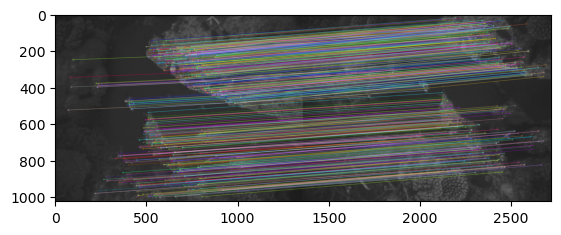

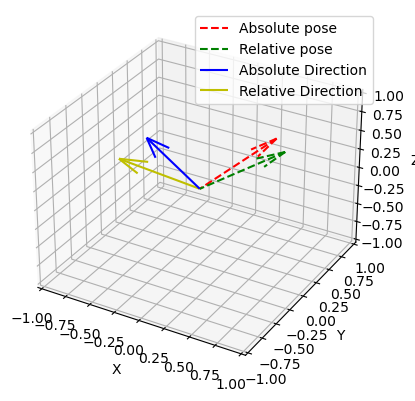

[[0.52341454 1.97311252 1.71735008]
 [1.83244982 0.41421349 1.84145935]
 [2.08259998 1.94195413 0.51704792]]


ValueError: `self.log(my_loss, [[0.52341454 1.97311252 1.71735008]
 [1.83244982 0.41421349 1.84145935]
 [2.08259998 1.94195413 0.51704792]])` was called, but `ndarray` values cannot be logged

In [11]:
torch.set_float32_matmul_precision('medium')
model = LitResnet(lr=0.5)
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger("tb_logs",log_graph=True, name="my_model")
trainer = Trainer(
    max_epochs=10,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=logger,
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
    log_every_n_steps= 20
)
trainer.fit(model, train_dataloader)

In [12]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')


In [13]:
device = torch.device('cuda:0')
#model = LitResnet.load_from_checkpoint("/home/turin/Documents/GitHub/long_term_underwater_vision/model/logs/lightning_logs/version_62/checkpoints/epoch=2-step=12.ckpt").to(device)
model = model.to(device)
data = train_dataloader
img,y = data.dataset.__getitem__(0)
img1, img2 = img
img1 = torch.unsqueeze(img1,0).to(device)
img2 = torch.unsqueeze(img2,0).to(device)
out = model([img1,img2])


torch.Size([1, 1, 1024, 1360]) torch.Size([1, 1, 1024, 1360])


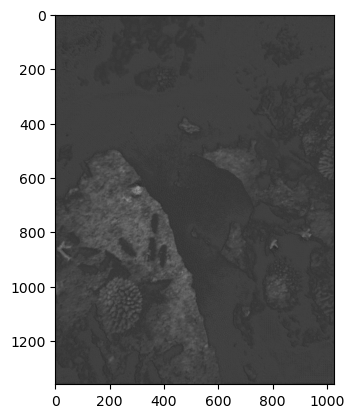

In [23]:
out1= out[0]
out1 = torch.squeeze(out1,0)
#out2 = torch.squeeze(out2,0)
out1= out1.T
#out2= out2.T
im1 = out1.cpu().detach()
#im2 = out2.cpu()
#
plt.imshow(im1, cmap = "gray")

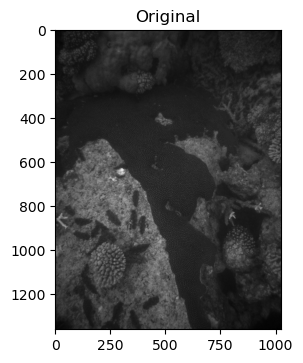

In [24]:
#Original Image
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img1.cpu().squeeze().T, cmap="gray")
# #Generated Image
# plt.subplot(1,2,2)
# plt.title("Generated")
# plt.imshow(im2.detach().numpy())

In [ ]:
x,y = data.dataset.__getitem__(1)
x = x[1]
img = x
img = torch.unsqueeze(img,0)
out = model(img)
out = torch.squeeze(out,0)
out = out.T
x = x.T
#Original Image
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(x.detach().numpy())
#Generated Image
plt.subplot(1,2,2)
plt.title("Generated")
plt.imshow(out.detach().numpy())

In [ ]:
vec = np.asarray([1.5,-3.4,2.1])
norm = np.linalg.norm(vec)
vec/norm


In [ ]:
torch.Tensor([1,3])


In [ ]:
pdist = nn.PairwiseDistance(p=2)
input1 = torch.randn(1,3,100, 128)
input2 = torch.randn(1,3,100, 128)
output = pdist(input1, input2)
output.mean(), input1.shape

In [ ]:
euclidean_distance = F.pairwise_distance(output1, output2, keepdim = False)
        #euclidean_distance = F.mse_loss(output1,output2)
        print(euclidean_distance.shape)

In [ ]:
cc = torch.Tensor([1])

In [ ]:
if cc:
    print(12)

In [ ]:
cc.requires_grad_()

In [ ]:
batch = iter(train_dataloader)
x,y = next(batch)
error = torch.abs(x[0][9]-x[1][9])
error.mean()

In [ ]:
im1 = plt.imread("/home/turin/Documents/GitHub/long_term_underwater_vision/dataset/"+np_data[12][0])
im2 = plt.imread("/home/turin/Documents/GitHub/long_term_underwater_vision/dataset/"+np_data[12][1])

In [ ]:
np.abs(im1-im2).mean(), np_label[12][0]